In [1]:
import cv2
import numpy as np
from pathlib import Path
from boxmot import DeepOCSORT, StrongSORT, BoTSORT
from ultralytics import YOLO
from pathlib import Path

In [34]:
def initialize_tracker(model_weights, device='cuda:0', fp16=True):
    """
    Initialize the DeepOCSORT tracker with the given model weights and device.
    """
    tracker = BoTSORT(
        model_weights=model_weights,
        device=device,
        fp16=fp16,
        match_thresh=0.9,
        proximity_thresh=0.2
    )
    return tracker

def initialize_yolo(model_path):
    """
    Initialize the YOLO object detector with the given model path.
    """
    yolov8 = YOLO(model_path)
    return yolov8

In [35]:
class Rect:
    def __init__(self, x1, y1, x2, y2):
        self.x1 = x1
        self.y1 = y1
        self.x2 = x2
        self.y2 = y2
    
    @property
    def bottom_center(self):
        return ((self.x1 + self.x2) // 2, self.y2)
    
    @property
    def width(self):
        return self.x2 - self.x1

class Color:
    def __init__(self, b, g, r):
        self.b = b
        self.g = g
        self.r = r

    @property
    def bgr_tuple(self):
        return (self.b, self.g, self.r)

def draw_ellipse(image, rect, color, thickness=2):
    center = rect.bottom_center
    axes = (int(rect.width), int(0.35 * rect.width))
    cv2.ellipse(
        image,
        center,
        axes,
        angle=0.0,
        startAngle=-45,
        endAngle=235,
        color=color.bgr_tuple,
        thickness=thickness,
        lineType=cv2.LINE_4
    )
    return image

def lab_to_rgb(lab_color):
    """
    Converts a single LAB color to RGB.
    """
    lab_image = np.array([[lab_color]], dtype=np.uint8)
    rgb_image = cv2.cvtColor(lab_image, cv2.COLOR_Lab2RGB)
    return rgb_image[0][0]

def create_new_file(file_name):
    """
    Check if a file already exists, if it does append a number to the file
    The number increases if a file_"number" exists
    """
    if Path(file_name).is_file():
        file = file_name.split(".")[0]
        extension = file_name.split(".")[1]
        last_char = file[len(file) - 1]
        if last_char.isnumeric():
            last_char = str(int(last_char) + 1)
            new_file =  file[:-1] + last_char + "." + extension
        else:
            last_char = "_1"
            new_file =  file + last_char + "." + extension
        
        return create_new_file(new_file)
    else:
        return file_name

In [36]:
def plot_kmeans_clusters(player_mean_colors, labels):
    player_mean_colors = np.array([lab_to_rgb(color) for color in player_mean_colors])

    # Plotting the results (optional)
    plt.subplot(1, 2, 1)
    plt.scatter(player_mean_colors[:, 1], player_mean_colors[:, 2], c=player_mean_colors / 255.0)
    plt.title('Original Colors')

    plt.subplot(1, 2, 2)
    plt.scatter(player_mean_colors[labels == 0][:, 1], player_mean_colors[labels == 0][:, 2], c='blue', marker='o')
    plt.scatter(player_mean_colors[labels == 1][:, 1], player_mean_colors[labels == 1][:, 2], c='red', marker='x')
    plt.title('Clustered Colors')

    plt.show()
    
def home_away_color_ranges(home, away):
    # plot_lab_region(home[0], home[1])
    plot_lab_region(away[0], away[1])

    plt.figure(figsize=(10, 5))

    # Displaying the mask
    plt.subplot(1, 4, 1)
     # Plotting the most common color
    plt.imshow(cv2.cvtColor(home[0][np.newaxis, np.newaxis, :].astype(np.uint8), cv2.COLOR_Lab2RGB))
    plt.title("Home Lower")

    plt.subplot(1, 4, 2)
    plt.imshow(cv2.cvtColor(home[1][np.newaxis, np.newaxis, :].astype(np.uint8), cv2.COLOR_Lab2RGB))
    plt.title("Home Upper")

    plt.subplot(1, 4, 3)
    plt.imshow(cv2.cvtColor(away[0][np.newaxis, np.newaxis, :].astype(np.uint8), cv2.COLOR_Lab2RGB))
    plt.title("Away Lower")

    plt.subplot(1, 4, 4)
    plt.imshow(cv2.cvtColor(away[1][np.newaxis, np.newaxis, :].astype(np.uint8), cv2.COLOR_Lab2RGB))
    plt.title("Away Upper")

    plt.show()

In [37]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import sys
import sklearn
from collections import Counter


def adjust_bbox(image, bbox, height_fraction=(0.17, 0.5), width_fraction=(0.2, 0.2)):
    x1, y1, x2, y2 = bbox
    
    # Adjusting the bounding box to focus on the upper part
    height = y2 - y1
    width = x2 - x1
    
    new_y1 = y1 + int(height_fraction[0] * height)
    new_y2 = y1 + int(height_fraction[1] * height)
    new_x1 = x1 + int(width_fraction[0] * width)
    new_x2 = x2 - int(width_fraction[1] * width)

    adjusted_bbox = (new_x1, new_y1, new_x2, new_y2)
    roi = image[adjusted_bbox[1]:adjusted_bbox[3], adjusted_bbox[0]:adjusted_bbox[2]]

    return roi

def filter_out_color_LAB(roi_lab, lower_treshold, upper_treshold):
    # Getting the A channel and applying threshold
    a_channel = roi_lab[:,:,1]
    #127, 255
    _, mask = cv2.threshold(a_channel, lower_treshold, upper_treshold, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Using the mask to exclude green pixels in LAB
    roi_lab_filtered = roi_lab.copy()
    roi_lab_filtered[mask != 255] = 0
    return roi_lab_filtered

def get_color_histogram(image, bbox):
    """
    Get the color histogram within a specific portion of the bounding box in the HSV color space.
    """
    roi = adjust_bbox(image, bbox)
    # Converting to LAB color space
    roi_lab = cv2.cvtColor(roi, cv2.COLOR_BGR2Lab)
    roi_lab_filtered = filter_out_color_LAB(roi_lab, 127, 255)
    
    non_black_pixels = roi_lab_filtered[roi_lab_filtered.any(axis=-1)]
    color_counter = Counter(map(tuple, non_black_pixels))
    most_common_color = color_counter.most_common(1)[0][0]
        
    non_zero_subarrays = roi_lab_filtered[roi_lab_filtered.any(axis=-1)]
    
    hist = cv2.calcHist([roi_lab], [0, 1], None, [8, 8], [0, 180, 0, 256])
    
    cv2.normalize(hist, hist)
    
    return hist.flatten()

def get_mean_color(image, bbox):
    """
    Get the mean color within a specific portion of the bounding box in both RGB and LAB color spaces,
    excluding green pixels.
    """
    roi = adjust_bbox(image, bbox)

    # Converting to LAB color space
    roi_lab = cv2.cvtColor(roi, cv2.COLOR_BGR2Lab)
    roi_lab_filtered = filter_out_color_LAB(roi_lab, 127, 255)
        
    non_zero_subarrays = roi_lab_filtered[roi_lab_filtered.any(axis=-1)]

    # Calculate the mean of each channel
    if non_zero_subarrays.size > 0:
        mean_color_lab = non_zero_subarrays.mean(axis=0)
        
        
    color_counter = Counter(map(tuple, non_zero_subarrays))
    most_common_color_lab = np.array(color_counter.most_common(1)[0][0], dtype=np.uint8)

    most_common_color_bgr = cv2.cvtColor(np.array([[most_common_color_lab]], dtype=np.uint8), cv2.COLOR_Lab2BGR)[0][0]
    mean_color_bgr = cv2.cvtColor(np.array([[mean_color_lab]], dtype=np.uint8), cv2.COLOR_Lab2BGR)[0][0]
    return most_common_color_lab, mean_color_lab

def perform_kmeans_clustering(colors, initial_centroids, color_multiplier=4, max_iter=10, n_clusters=2):
    """
    Perform k-means clustering on the given color data.
    """
    colors = np.array(colors)
    
    colors[:,1:3] *= 4
    if len(initial_centroids) != 0:
        kmeans = KMeans(n_clusters=2, init=initial_centroids, random_state=0, n_init=1, max_iter=max_iter).fit(colors)
    else:
        kmeans = KMeans(n_clusters=2, random_state=0).fit(colors)
        initial_centroids = kmeans.cluster_centers_
        
    # Reassign labels based on the order of centroids
    sorted_idx = np.argsort(initial_centroids[:, 0])  # Assuming the 0th feature is a color channel like Red
    mapping = np.zeros(n_clusters, dtype=int)
    for i, idx in enumerate(sorted_idx):
        mapping[idx] = i

    consistent_labels = mapping[kmeans.labels_]
    
    return consistent_labels, initial_centroids

In [38]:
from scipy.spatial import distance
from scipy import stats
    
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection



def plot_filtered_boxes(frame, boxes):
    plt.figure(figsize=(12, len(boxes) * 4))
    
    for i, box in enumerate(boxes):
        # Apply the ROI adjustment and color filtering
        roi = adjust_bbox(frame, box)
        roi_lab = cv2.cvtColor(roi, cv2.COLOR_BGR2Lab)
        roi_lab_filtered = filter_out_color_LAB(roi_lab, 127, 255)
        non_zero_colors = roi_lab_filtered[roi_lab_filtered.any(axis=-1)]

        plt.subplot(len(boxes), 2, i * 2 + 1)
        plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
        plt.title(f"Original Box {i+1}")

        plt.subplot(len(boxes), 2, i * 2 + 2)
        plt.imshow(cv2.cvtColor(roi_lab_filtered, cv2.COLOR_Lab2RGB))
        plt.title(f"Filtered Box {i+1}")
        
    plt.show()

def compute_common_color_cluster_and_range(frame, boxes, num_clusters=2, delta=10):
    colors = []
    for box in boxes:
        roi = adjust_bbox(frame, box)
        roi_lab = cv2.cvtColor(roi, cv2.COLOR_BGR2Lab)
        roi_lab_filtered = filter_out_color_LAB(roi_lab, 127, 255)
        non_zero_colors = roi_lab_filtered[roi_lab_filtered.any(axis=-1)]
        colors.extend(non_zero_colors)

    if len(colors) == 0:
        print("All colors are filtered out.")
        return None, None

    # Applying K-means clustering to group colors
    kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(colors)
    cluster_centers = kmeans.cluster_centers_.astype(int)

    # Getting the most common cluster center (centroid)
    labels, counts = np.unique(kmeans.labels_, return_counts=True)
    most_common_cluster = cluster_centers[labels[np.argmax(counts)]]

    # Compute the color range
    lower_bound = np.clip(most_common_cluster - delta, 0, 255)
    upper_bound = np.clip(most_common_cluster + delta, 0, 255)

    # Plotting the most common color cluster center
    plt.figure(figsize=(6, 2))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(most_common_cluster[np.newaxis, np.newaxis, :].astype(np.uint8), cv2.COLOR_Lab2RGB))
    plt.title("Most Common Cluster Center")
    plt.axis('off')

    # Plotting colors within the range
    plt.subplot(1, 2, 2)
    for i in range(5):
        sample_color = np.random.randint(lower_bound, upper_bound+1)
        plt.imshow(cv2.cvtColor(sample_color[np.newaxis, np.newaxis, :].astype(np.uint8), cv2.COLOR_Lab2RGB))
        plt.title("Colors Within Range")
        plt.axis('off')

    plt.show()

    return lower_bound, upper_bound    
    
def compute_common_color_and_range(frame, boxes, delta=10):
    colors = []
    for box in boxes:
        roi = adjust_bbox(frame, box)
        roi_lab = cv2.cvtColor(roi, cv2.COLOR_BGR2Lab)
        roi_lab_filtered = filter_out_color_LAB(roi_lab, 127, 255)
        non_zero_colors = roi_lab_filtered[roi_lab_filtered.any(axis=-1)]
        colors.extend(non_zero_colors)

    if len(colors) == 0:
        print("All colors are filtered out.")
        return None, None

    color_counter = Counter(map(tuple, colors))
    most_common_color = np.array(color_counter.most_common(1)[0][0], dtype=np.uint8)

    # Compute the color range
    lower_bound = most_common_color - delta
    upper_bound = most_common_color + delta
    
    # Ensure the bounds are valid
    if np.any(upper_bound < lower_bound):
        print("Invalid color range corrected.")
        lower_bound = most_common_color
        upper_bound = most_common_color
    
    lower_bound = np.clip(lower_bound, 0, 255)
    upper_bound = np.clip(upper_bound, 0, 255)

    # Plotting the most common color
    plt.figure(figsize=(6, 2))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(most_common_color[np.newaxis, np.newaxis, :].astype(np.uint8), cv2.COLOR_Lab2RGB))
    plt.title("Most Common Color")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    for i in range(5):
        sample_color = np.random.randint(lower_bound, upper_bound + 1, size=(1,1,3))
        plt.imshow(cv2.cvtColor(sample_color.astype(np.uint8), cv2.COLOR_Lab2RGB))
        plt.axis('off')

    return lower_bound, upper_bound


def nearest_points(centroids, data_points, n):
    # Calculate the distances between each data point and each centroid
    distances = distance.cdist(data_points, centroids, 'euclidean')
    
    # Get the n smallest distances' indices for each centroid
    nearest_indices = np.argsort(distances, axis=0)[:n]
    
    # Creating a dictionary to hold the indices of the nearest points for each centroid
    nearest_per_centroid = {i: nearest_indices[:, i].tolist() for i in range(centroids.shape[0])}

    return nearest_per_centroid


def compute_jersey_colors(first_frame, dets, bounding_boxes, classes, color_multiplier=4):
    # get_mean_color returns a tuple, 0 is most common color, 1 is mean color
    class_1_boxes = [bounding_box for bounding_box, cls in zip(bounding_boxes, classes) if cls == 1]
    colors_bounding_boxes = [(get_mean_color(first_frame, bounding_box)[1], bounding_box) for bounding_box in class_1_boxes]
    
    mean_colors = []
    for color_bbox in colors_bounding_boxes:
        mean_colors.append(color_bbox[0])
    
    initial_centroids = []
    mean_colors = np.array(mean_colors)
    label_clusters, centroids = perform_kmeans_clustering(mean_colors, initial_centroids, color_multiplier=color_multiplier)
    clustered_points = mean_colors.copy()
    clustered_points[:,1:3] *= color_multiplier
    
    close_points = nearest_points(centroids, clustered_points, 4)
    
    centroid_1_boxes = [class_1_boxes[i] for i in close_points[0]]
    centroid_2_boxes = [class_1_boxes[i] for i in close_points[1]]
    
    
    #plot_filtered_boxes(first_frame, centroid_1_boxes)
    #plot_filtered_boxes(first_frame, centroid_2_boxes)
    print("first")
    home1 = compute_common_color_cluster_and_range(first_frame, centroid_1_boxes)
    home = compute_common_color_and_range(first_frame, centroid_1_boxes)

    print("second")
    away1 = compute_common_color_cluster_and_range(first_frame, centroid_2_boxes)
    away = compute_common_color_and_range(first_frame, centroid_2_boxes)


    print("Most Dominant Color (in LAB):", away1)
    return (home, away)
    

def plot_lab_region(lower_bound, upper_bound):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Define the vertices of the region
    # Each vertex is a combination of the lower and upper values for L, a, and b
    vertices = [
        [lower_bound[0], lower_bound[1], lower_bound[2]],
        [upper_bound[0], lower_bound[1], lower_bound[2]],
        [upper_bound[0], upper_bound[1], lower_bound[2]],
        [lower_bound[0], upper_bound[1], lower_bound[2]],
        [lower_bound[0], lower_bound[1], upper_bound[2]],
        [upper_bound[0], lower_bound[1], upper_bound[2]],
        [upper_bound[0], upper_bound[1], upper_bound[2]],
        [lower_bound[0], upper_bound[1], upper_bound[2]]
    ]
    
    vertices = np.array(vertices)
    
    # Define the vertices that compose each of the 6 faces of the region
    faces = [
        [vertices[0], vertices[1], vertices[2], vertices[3]],
        [vertices[4], vertices[5], vertices[6], vertices[7]], 
        [vertices[0], vertices[1], vertices[5], vertices[4]], 
        [vertices[1], vertices[2], vertices[6], vertices[5]],
        [vertices[2], vertices[3], vertices[7], vertices[6]],
        [vertices[3], vertices[0], vertices[4], vertices[7]]
    ]
    
    # Draw the faces
    ax.add_collection3d(Poly3DCollection(faces, facecolors='cyan', linewidths=1, edgecolors='black', alpha=.25))
    
    ax.set_xlabel('L*')
    ax.set_ylabel('a*')
    ax.set_zlabel('b*')
    ax.set_xlim([0, 255])
    ax.set_ylim([-255, 255])
    ax.set_zlim([-255, 255])
    plt.show()

        
def get_team_belonging(image, bounding_box, home_color, away_color, should_plot=False):
    #blur_kernel_size = (2,2)
    #image = cv2.blur(image, blur_kernel_size)
    roi = adjust_bbox(image, bounding_box)
    
    # Converting to LAB color space
    roi_lab = cv2.cvtColor(roi, cv2.COLOR_BGR2LAB)
    
    roi_lab_away = roi_lab.copy()
    roi_lab_referee = roi_lab.copy()
    
    lower_blue = np.array([100, 50, 50])
    upper_blue = np.array([140, 255, 255])
    
    lower_white = np.array([0, 0, 200])
    upper_white = np.array([180, 50, 255])
    
    
    mask_home = cv2.inRange(roi_lab, home_color[0], home_color[1])
    #mask_home = cv2.inRange(roi_lab, lower_blue, upper_blue)
    result_home = cv2.bitwise_and(roi_lab, roi_lab, mask=mask_home)
    count_home = cv2.countNonZero(mask_home)
    
    mask_away = cv2.inRange(roi_lab_away, away_color[0], away_color[1])
    #mask_away = cv2.inRange(roi_lab_away, lower_white, upper_white)
    result_away = cv2.bitwise_and(roi_lab_away, roi_lab_away, mask=mask_away)
    count_away = cv2.countNonZero(mask_away)
    
    if should_plot:
        plt.figure(figsize=(10, 5))
        # Displaying the mask
        plt.subplot(1, 5, 1)
        plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
        plt.title("Result")

        plt.subplot(1, 5, 2)
        plt.imshow(mask_home, cmap='gray')
        plt.title("Mask Home")

        # Displaying the result
        plt.subplot(1, 5, 3)
        plt.imshow(cv2.cvtColor(result_home, cv2.COLOR_HSV2RGB))
        plt.title("Result Home")

        plt.subplot(1, 5, 4)
        plt.imshow(mask_away, cmap='gray')
        plt.title("Mask Away")

        # Displaying the result
        plt.subplot(1, 5, 5)
        plt.imshow(cv2.cvtColor(result_away, cv2.COLOR_HSV2RGB))
        plt.title("Result Away")

        plt.show()
        
        
    team = -1
    
    if count_away > count_home:
        team = 1
        print("Away team")
    else:
        print("Home team")
        team = 0
        
    return team

In [39]:
import os
import cv2
import zipfile

# Function to get unique colors for each class id
def get_color(cls_id):
    np.random.seed(cls_id)
    return tuple(np.random.randint(0, 255, 3).tolist())

def split_ball_players(detections):
    dets = []
    ball = np.array([])
    highest_conf = 0

    for bounding_boxes in detections:
        if bounding_boxes[-1:] != 0:
            dets.append(bounding_boxes)
        if bounding_boxes[5] == 0:
            if bounding_boxes[4] > highest_conf:
                highest_conf = bounding_boxes[4]
                ball = bounding_boxes


    dets = np.array(dets)
    
    return dets, ball

def draw_on_frame(image, xyxys, ids, clss, labels, ball):
    thickness = 2
    fontscale = 0.5

    
    for xyxy, id, cls, label in zip(xyxys, ids, clss, labels):


        # Convert bounding box coordinates to Rect object
        rect = Rect(xyxy[0], xyxy[1], xyxy[2], xyxy[3])
        if cls == 1:
            cls = cls + label

        # Get a unique color for each class
        color = Color(*get_color(cls))

        # Draw an ellipse at the bottom of the bounding box
        draw_ellipse(image, rect, color, thickness)

        # Place ID text just above the ellipse
        cv2.putText(
            image,
            f'{id}',
            (rect.bottom_center[0] - 10, rect.bottom_center[1] - int(0.35 * rect.width) - 5),
            cv2.FONT_HERSHEY_SIMPLEX,
            fontscale,
            color.bgr_tuple,
            thickness
        )
    if len(ball) != 0:
        rect = Rect(int(ball[0]), int(ball[1]), int(ball[2]), int(ball[3]))
        # Get a unique color for each class
        color = Color(*get_color(0))

        # Draw an ellipse at the bottom of the bounding box
        draw_ellipse(image, rect, color, thickness)
        id = -1
        # Place ID text just above the ellipse
        cv2.putText(
            image,
            "-1",
            (rect.bottom_center[0] - 10, rect.bottom_center[1] - int(0.35 * rect.width) - 5),
            cv2.FONT_HERSHEY_SIMPLEX,
            fontscale,
            color.bgr_tuple,
            thickness
        )
        
        
def save_frame_as_image(frame, output_folder, frame_id):
    """Save the current frame as an image."""
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    filename = os.path.join(output_folder, f"{frame_id:06}.jpg")
    print("Saved: " + filename)
    cv2.imwrite(filename, frame)

def write_labels_txt(class_names, filepath):
    """Write class names to labels.txt."""
    with open(filepath, "w") as f:
        for name in class_names:
            f.write(name + "\n")

def export_to_mot_format(frames, track_ids, bboxes, class_ids, filepath):
    """Write the tracking results into gt.txt in the MOT format."""
    with open(filepath, 'w') as f:
        for frame_num, track_id, bbox, class_id in zip(frames, track_ids, bboxes, class_ids):
            x1, y1, x2, y2 = bbox
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
            w = x2 - x1
            h = y2 - y1
            f.write(f"{frame_num},{track_id},{x1},{y1},{w},{h},1,{class_id},0.86014\n")


In [40]:
def process_video(input_file, output_file, tracker, yolov8, do_kmeans, conf=0.8, should_plot=False, class_names=None):
    """
    Process the input video, perform object detection and tracking, and save the results to the output video.
    """
    input_video = cv2.VideoCapture(input_file)
    width = int(input_video.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(input_video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = input_video.get(cv2.CAP_PROP_FPS)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_file, fourcc, fps, (width, height))
  
    initial_centroids = []
    counter = 1
    while True:
        print(counter)
        ret, image = input_video.read()
        if not ret:
            break
        
       
        predicted = yolov8.predict(image, conf=conf)
        detections = predicted[0].boxes.data.cpu().numpy()
        
        # Split the ball detections and player detections into two arrays
        # This ensures the labels are correct when doing team assignment
        # and that we only get 1 ball in each frame
        dets, ball = split_ball_players(detections)
        
        tracks = tracker.update(dets, image)
        
        # Set im = image so we can do transforms on the image for better color identification
        # Without altering the original image so when writing the video it looks the same
        #im = cv2.addWeighted(image, 0.75, image, 0.5, 0)
        im = image
        
        if tracks.size > 0:  # Check if tracks is not empty
            xyxys = tracks[:, 0:4].astype('int')
            ids = tracks[:, 4].astype('int')
            clss = tracks[:, 6].astype('int')
        else:
            print("Tracks is empty or not in expected format.")

        if(counter == 1):
            home, away = compute_jersey_colors(im, dets, xyxys, clss)
            
            if should_plot:
                home_away_color_ranges(home, away)
            
            
        if tracks.shape[0] != 0:
            player_mean_colors = [get_mean_color(im, xyxy)[1] for xyxy, cls in zip(xyxys, clss) if cls == 1]
            #player_mean_colors = [get_color_histogram(im, xyxy) for xyxy, cls in zip(xyxys, clss) if cls == 1]
            
            if(len(initial_centroids) == 0):
                labels, initial_centroids = perform_kmeans_clustering(player_mean_colors, initial_centroids)

            else:
                if do_kmeans:
                    labels = perform_kmeans_clustering(player_mean_colors, initial_centroids)[0]
                else:
                    labels = [get_team_belonging(im, xyxy, home, away) for xyxy, cls in zip(xyxys, clss) if cls == 1]
            
            if should_plot:
                plot_kmeans_clusters(player_mean_colors, labels)   
    
            draw_on_frame(image, xyxys, ids, clss, labels, ball)

        out.write(image)
        counter += 1
        
    input_video.release()
    out.release()
    cv2.destroyAllWindows()


2023-11-01 11:39:19.903 | SUCCESS  | boxmot.appearance.reid_model_factory:load_pretrained_weights:207 - Successfully loaded pretrained weights from "osnet_x1_0_market1501.pt"


Tracking output: videos/30sec_BODO_tracking_output_test.mp4
1



0: 1088x1920 1 ball, 22 players, 58.4ms
Speed: 47.2ms preprocess, 58.4ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


first


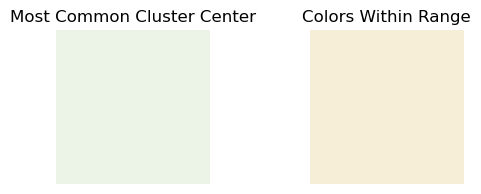

Invalid color range corrected.
second


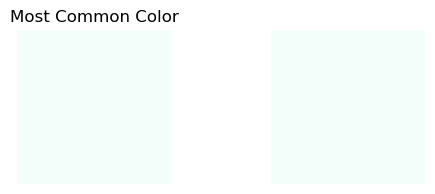

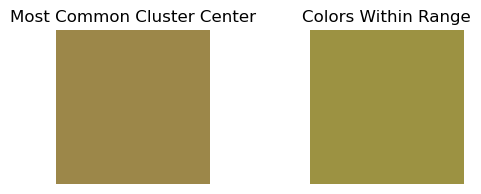

Most Dominant Color (in LAB): (array([135, 118, 154]), array([155, 138, 174]))



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


2



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.0ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


3
4



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


5
6



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.8ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


7
8



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


9
10



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


11
12



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


13
14



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


15
16



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.9ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


17
18



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


19
20



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


21
22



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


23
24



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


25
26



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


27
28



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


29
30



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


31
32



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


33
34



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


35
36



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


37
38



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


39
40



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


41
42



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.0ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


43
44



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


45
46



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


47
48



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


49
50



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


51
52



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


53
54



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


55
56



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


57
58



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


59
60



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


61
62



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


63
64



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


65
66



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


67
68



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


69
70



0: 1088x1920 22 players, 17.9ms
Speed: 7.9ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


71
72



0: 1088x1920 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


73
74



0: 1088x1920 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 6.8ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


75
76



0: 1088x1920 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


77
78



0: 1088x1920 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


79
80



0: 1088x1920 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


81
82



0: 1088x1920 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


83
84



0: 1088x1920 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


85
86



0: 1088x1920 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


87
88



0: 1088x1920 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


89
90



0: 1088x1920 22 players, 17.9ms
Speed: 7.0ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


91
92



0: 1088x1920 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


93
94



0: 1088x1920 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 18.2ms
Speed: 7.8ms preprocess, 18.2ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


95
96



0: 1088x1920 22 players, 17.9ms
Speed: 7.8ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


97
98



0: 1088x1920 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


99
100



0: 1088x1920 22 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


101
102



0: 1088x1920 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


103
104



0: 1088x1920 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


105
106



0: 1088x1920 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


107
108



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


109
110



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


111
112



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.8ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


113
114



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.9ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


115
116



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.0ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


117
118



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


119
120



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


121
122



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


123
124



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 8.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


125
126



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


127
128



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


129
130



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


131
132



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


133
134



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


135
136



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


137
138



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


139
140



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.9ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


141
142



0: 1088x1920 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


143
144



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.0ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


145
146



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


147
148



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


149
150



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


151
152



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.9ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


153
154



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


155
156



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


157
158



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


159
160



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


161
162



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


163
164



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


165
166



0: 1088x1920 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


167
168



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


169
170



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


171
172



0: 1088x1920 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


173
174



0: 1088x1920 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


175
176



0: 1088x1920 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


177
178



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


179
180



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


181
182



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


183
184



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


185
186



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


187
188



0: 1088x1920 21 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 21 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


189
190



0: 1088x1920 1 ball, 20 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


191
192



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


193
194



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


195
196



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


197
198



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


199
200



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


201
202



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


203
204



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


205
206



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


207
208



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


209
210



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


211
212



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


213
214



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 8.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


215
216



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


217
218



0: 1088x1920 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


219
220



0: 1088x1920 22 players, 17.9ms
Speed: 7.8ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


221
222



0: 1088x1920 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


223
224



0: 1088x1920 22 players, 17.9ms
Speed: 8.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


225
226



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


227
228



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


229
230



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


231
232



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.9ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


233
234



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.8ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


235
236



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


237
238



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


239
240



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 8.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


241
242



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 21 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


243
244



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


245
246



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


247
248



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


249
250



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


251
252



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


253
254



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


255
256



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.9ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


257
258



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


259
260



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


261
262



0: 1088x1920 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


263
264



0: 1088x1920 1 ball, 22 players, 34.7ms
Speed: 7.5ms preprocess, 34.7ms inference, 1.4ms postprocess per image at shape (1, 3, 1088, 1920)


265



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


266
267



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


268
269



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 8.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


270
271



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


272
273



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


274
275



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.0ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


276
277



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


278
279



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


280
281



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


282
283



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


284
285



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.9ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


286
287



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


288
289



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.8ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


290
291



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


292
293



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


294
295



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.8ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


296
297



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


298
299



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.8ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


300
301



0: 1088x1920 1 ball, 22 players, 18.0ms
Speed: 7.6ms preprocess, 18.0ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 21 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


302
303



0: 1088x1920 21 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 21 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


304
305



0: 1088x1920 21 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


306
307



0: 1088x1920 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


308
309



0: 1088x1920 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


310
311



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


312
313



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.9ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


314
315



0: 1088x1920 22 players, 17.9ms
Speed: 7.0ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


316
317



0: 1088x1920 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


318
319



0: 1088x1920 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


320
321



0: 1088x1920 22 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


322
323



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


324
325



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


326
327



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


328
329



0: 1088x1920 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


330
331



0: 1088x1920 22 players, 17.9ms
Speed: 8.0ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


332
333



0: 1088x1920 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


334
335



0: 1088x1920 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


336
337



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


338
339



0: 1088x1920 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


340
341



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.0ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


342
343



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.8ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


344
345



0: 1088x1920 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


346
347



0: 1088x1920 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


348
349



0: 1088x1920 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


350
351



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


352
353



0: 1088x1920 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.8ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


354
355



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


356
357



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.0ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


358
359



0: 1088x1920 22 players, 17.9ms
Speed: 7.0ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


360
361



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


362
363



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


364
365



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 21 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


366
367



0: 1088x1920 1 ball, 21 players, 17.9ms
Speed: 8.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 21 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


368
369



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


370
371



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


372
373



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


374
375



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


376
377



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


378
379



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 21 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


380
381



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


382
383



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


384
385



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


386
387



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


388
389



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


390
391



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


392
393



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


394
395



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 8.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


396
397



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


398
399



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.8ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.0ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


400
401



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


402
403



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.9ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


404
405



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


406
407



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


408
409



0: 1088x1920 1 ball, 21 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


410
411



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


412
413



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 8.0ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


414
415



0: 1088x1920 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


416
417



0: 1088x1920 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


418
419



0: 1088x1920 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


420
421



0: 1088x1920 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


422
423



0: 1088x1920 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


424
425



0: 1088x1920 23 players, 18.0ms
Speed: 7.7ms preprocess, 18.0ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


426
427



0: 1088x1920 23 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 17.9ms
Speed: 7.8ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


428
429



0: 1088x1920 23 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


430
431



0: 1088x1920 23 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


432
433



0: 1088x1920 23 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


434
435



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.0ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


436
437



0: 1088x1920 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


438
439



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


440
441



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.8ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


442
443



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


444
445



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


446
447



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


448
449



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


450
451



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


452
453



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


454
455



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 18.0ms
Speed: 7.7ms preprocess, 18.0ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


456
457



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


458
459



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


460
461



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.0ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


462
463



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 19.4ms
Speed: 7.9ms preprocess, 19.4ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


464
465



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


466
467



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


468
469



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


470
471



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.0ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


472
473



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.8ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


474
475



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.8ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


476
477



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.0ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


478
479



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


480
481



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.9ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


482
483



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


484
485



0: 1088x1920 23 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


486
487



0: 1088x1920 23 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


488
489



0: 1088x1920 23 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


490
491



0: 1088x1920 23 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


492
493



0: 1088x1920 23 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


494
495



0: 1088x1920 23 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.8ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


496
497



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


498
499



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


500
501



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


502
503



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


504
505



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


506
507



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.0ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.9ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


508
509



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


510
511



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 8.0ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


512
513



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


514
515



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


516
517



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.0ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


518
519



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


520
521



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.0ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


522
523



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


524
525



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


526
527



0: 1088x1920 23 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


528
529



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


530
531



0: 1088x1920 23 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


532
533



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


534
535



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


536
537



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


538
539



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.8ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


540
541



0: 1088x1920 1 ball, 23 players, 19.0ms
Speed: 7.2ms preprocess, 19.0ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.8ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


542
543



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.5ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


544
545



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


546
547



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


548
549



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


550
551



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


552
553



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


554
555



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


556
557



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


558
559



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


560
561



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.8ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


562
563



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


564
565



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


566
567



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


568
569



0: 1088x1920 23 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


570
571



0: 1088x1920 23 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 17.9ms
Speed: 7.0ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


572
573



0: 1088x1920 23 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


574
575



0: 1088x1920 23 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


576
577



0: 1088x1920 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


578
579



0: 1088x1920 23 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


580
581



0: 1088x1920 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


582
583



0: 1088x1920 23 players, 17.9ms
Speed: 7.0ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


584
585



0: 1088x1920 23 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


586
587



0: 1088x1920 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


588
589



0: 1088x1920 23 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


590
591



0: 1088x1920 23 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


592
593



0: 1088x1920 23 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


594
595



0: 1088x1920 23 players, 17.9ms
Speed: 7.9ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


596
597



0: 1088x1920 23 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 17.9ms
Speed: 7.8ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


598
599



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


600
601



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 6.9ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


602
603



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


604
605



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.0ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


606
607



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


608
609



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


610
611



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


612
613



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


614
615



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.8ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


616
617



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


618
619



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


620
621



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


622
623



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


624
625



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


626
627



0: 1088x1920 1 ball, 23 players, 18.0ms
Speed: 9.0ms preprocess, 18.0ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


628
629



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


630
631



0: 1088x1920 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


632
633



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.0ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.0ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


634
635



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


636
637



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


638
639



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


640
641



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 8.2ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


642
643



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


644
645



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.0ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.0ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


646
647



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


648
649



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


650
651



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


652
653



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.8ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


654
655



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


656
657



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


658
659



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


660
661



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


662
663



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


664
665



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.0ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


666
667



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


668
669



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


670
671



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


672
673



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


674
675



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


676
677



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


678
679



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


680
681



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


682
683



0: 1088x1920 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


684
685



0: 1088x1920 22 players, 17.9ms
Speed: 8.0ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 21 players, 17.9ms
Speed: 9.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


686
687



0: 1088x1920 21 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 21 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


688
689



0: 1088x1920 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 21 players, 17.9ms
Speed: 8.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


690
691



0: 1088x1920 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


692
693



0: 1088x1920 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 21 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


694
695



0: 1088x1920 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


696
697



0: 1088x1920 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


698
699



0: 1088x1920 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


700
701



0: 1088x1920 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 21 players, 18.0ms
Speed: 7.7ms preprocess, 18.0ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


702
703



0: 1088x1920 22 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


704
705



0: 1088x1920 23 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


706
707



0: 1088x1920 21 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


708
709



0: 1088x1920 23 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


710
711



0: 1088x1920 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


712
713



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.0ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


714
715



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 24 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


716
717



0: 1088x1920 1 ball, 24 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 24 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


718
719



0: 1088x1920 1 ball, 24 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 24 players, 17.9ms
Speed: 7.0ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


720
721



0: 1088x1920 1 ball, 24 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


722
723



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


724
725



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.0ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


726
727



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


728
729



0: 1088x1920 1 ball, 24 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


730
731



0: 1088x1920 1 ball, 24 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 24 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


732
733



0: 1088x1920 1 ball, 24 players, 17.9ms
Speed: 8.0ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 24 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


734
735



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 8.2ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


736
737



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


738
739



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.0ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 18.0ms
Speed: 8.0ms preprocess, 18.0ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


740
741



0: 1088x1920 23 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 24 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


742
743



0: 1088x1920 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 24 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


744
745



0: 1088x1920 1 ball, 24 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 24 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


746
747



0: 1088x1920 23 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 24 players, 17.9ms
Speed: 8.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


748
749



0: 1088x1920 24 players, 17.9ms
Speed: 7.8ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 24 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


750
751



0: 1088x1920 24 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 24 players, 17.9ms
Speed: 7.8ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


752
753



0: 1088x1920 23 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


754
755



0: 1088x1920 24 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 24 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


756
757



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


758
759



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


760
761



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


762
763



0: 1088x1920 23 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


764
765



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 6.9ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


766
767



0: 1088x1920 1 ball, 23 players, 17.9ms
Speed: 7.9ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


768
769



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


770
771



0: 1088x1920 24 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 24 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


772
773



0: 1088x1920 22 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


774
775



0: 1088x1920 22 players, 17.9ms
Speed: 7.0ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


776
777



0: 1088x1920 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


778
779



0: 1088x1920 23 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


780
781



0: 1088x1920 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 23 players, 17.9ms
Speed: 8.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


782
783



0: 1088x1920 23 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


784
785



0: 1088x1920 23 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


786
787



0: 1088x1920 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


788
789



0: 1088x1920 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 21 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


790
791



0: 1088x1920 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


792
793



0: 1088x1920 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 21 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


794
795



0: 1088x1920 21 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 21 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


796
797



0: 1088x1920 21 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 21 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


798
799



0: 1088x1920 21 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 21 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


800
801



0: 1088x1920 21 players, 17.9ms
Speed: 7.9ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 21 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


802
803



0: 1088x1920 21 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 21 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


804
805



0: 1088x1920 21 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 21 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


806
807



0: 1088x1920 21 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 21 players, 17.9ms
Speed: 7.0ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


808
809



0: 1088x1920 21 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 21 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


810
811



0: 1088x1920 21 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 21 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


812
813



0: 1088x1920 21 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 21 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


814
815



0: 1088x1920 20 players, 17.9ms
Speed: 7.8ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 21 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


816
817



0: 1088x1920 1 ball, 21 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 21 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


818
819



0: 1088x1920 21 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 21 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


820
821



0: 1088x1920 21 players, 17.9ms
Speed: 7.9ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 21 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


822
823



0: 1088x1920 20 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 20 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


824
825



0: 1088x1920 21 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 21 players, 17.9ms
Speed: 7.0ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


826
827



0: 1088x1920 21 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 21 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


828
829



0: 1088x1920 21 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 21 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


830
831



0: 1088x1920 21 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 21 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


832
833



0: 1088x1920 20 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 21 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


834
835



0: 1088x1920 21 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 21 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


836
837



0: 1088x1920 21 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 21 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


838
839



0: 1088x1920 21 players, 17.9ms
Speed: 8.1ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 20 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


840
841



0: 1088x1920 21 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 21 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


842
843



0: 1088x1920 1 ball, 20 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 20 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


844
845



0: 1088x1920 1 ball, 20 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 21 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


846
847



0: 1088x1920 21 players, 17.9ms
Speed: 7.0ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 21 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


848
849



0: 1088x1920 21 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 21 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


850
851



0: 1088x1920 21 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 21 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


852
853



0: 1088x1920 21 players, 17.9ms
Speed: 7.0ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


854
855



0: 1088x1920 22 players, 17.9ms
Speed: 8.0ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 21 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


856
857



0: 1088x1920 21 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


858
859



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


860
861



0: 1088x1920 21 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


862
863



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


864
865



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.8ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


866
867



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


868
869



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


870
871



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 8.0ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


872
873



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


874
875



0: 1088x1920 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 21 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


876
877



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.9ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


878
879



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


880
881



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


882
883



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


884
885



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.9ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


886
887



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


888
889



0: 1088x1920 22 players, 17.9ms
Speed: 7.0ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


890
891



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.2ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


892
893



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.4ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)


894
895



0: 1088x1920 1 ball, 21 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


896
897



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)


898
899



0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.5ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 ball, 22 players, 17.9ms
Speed: 7.7ms preprocess, 17.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1088, 1920)


900
901
902
Time taken to process video: 114.45556116104126 seconds


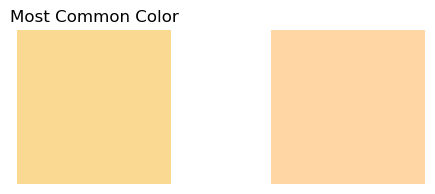

In [41]:
from pathlib import Path
import warnings
import time

warnings.filterwarnings("ignore")
model_weights = Path('osnet_x1_0_market1501.pt')
yolo_model_path = 'runs/detect/6600_Additional_images/weights/best.pt'
input_video_file = "videos/30sec_BODO.mp4"
output_video_name = create_new_file(input_video_file.split(".")[0] + "_tracking_output_test.mp4")

print("Tracking output: " + output_video_name)
output_video_file = output_video_name

# home_team_color="white"
# away_team_color="blue"

tracker = initialize_tracker(model_weights)
yolov8 = initialize_yolo(yolo_model_path)

class_names = ["player", "ball"] 

start_time = time.time()
process_video(input_video_file, output_video_file, tracker, yolov8, do_kmeans=True, should_plot=False, class_names=class_names)
end_time = time.time()

execution_time = end_time - start_time

print(f"Time taken to process video: {execution_time} seconds")

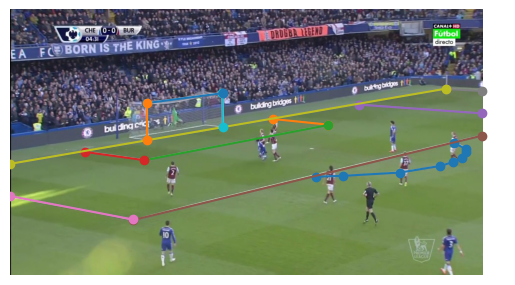

In [44]:
import matplotlib.pyplot as plt
import json
import os

# Load the JSON data
filename = "Calibration_Keypoint/00000.json"
with open(filename, 'r') as f:
    data = json.load(f)

# Load the image
img = plt.imread(filename.replace(".json", ".jpg"))  # assuming it's a .jpg, adjust as needed
plt.imshow(img)

# Plot each set of points
for key, points in data.items():
    # Extract x and y coordinates
    x = [point['x'] for point in points]
    y = [point['y'] for point in points]
    
    # Scale the coordinates to the image dimensions
    h, w, _ = img.shape
    x = [i * w for i in x]
    y = [j * h for j in y]
    
    # Draw the shape
    plt.plot(x, y, label=key, marker='o')

plt.axis('off')  # to hide axes

# Display or save the image
plt.show()
#plt.savefig(os.path.splitext(filename)[0] + "_output.jpg", bbox_inches='tight', pad_inches=0)


In [11]:
import zipfile
with zipfile.ZipFile('training.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [13]:
import os

def prepend_to_filenames(directory, prefix):
    """
    Prepend a prefix to all files in the given directory.
    
    :param directory: Path to the directory.
    :param prefix: The prefix to prepend.
    """
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)

        # Ensure we are working with files and not subdirectories
        if os.path.isfile(file_path):
            new_file_path = os.path.join(directory, prefix + filename)
            os.rename(file_path, new_file_path)
            print(f'Renamed {filename} to {prefix + filename}')

target_directory = 'Training1800/images'  # Replace with your directory path
prepend_to_filenames(target_directory, 'DataSet')


Renamed 000881.jpg to DataSet000881.jpg
Renamed 001506.jpg to DataSet001506.jpg
Renamed 001694.jpg to DataSet001694.jpg
Renamed 000094.jpg to DataSet000094.jpg
Renamed 000210.jpg to DataSet000210.jpg
Renamed 001751.jpg to DataSet001751.jpg
Renamed 000119.jpg to DataSet000119.jpg
Renamed 000879.jpg to DataSet000879.jpg
Renamed 001394.jpg to DataSet001394.jpg
Renamed 000305.jpg to DataSet000305.jpg
Renamed 000028.jpg to DataSet000028.jpg
Renamed 000366.jpg to DataSet000366.jpg
Renamed 001045.jpg to DataSet001045.jpg
Renamed 001785.jpg to DataSet001785.jpg
Renamed 001405.jpg to DataSet001405.jpg
Renamed 000642.jpg to DataSet000642.jpg
Renamed 000427.jpg to DataSet000427.jpg
Renamed 001207.jpg to DataSet001207.jpg
Renamed 001425.jpg to DataSet001425.jpg
Renamed 000844.jpg to DataSet000844.jpg
Renamed 000051.jpg to DataSet000051.jpg
Renamed 000272.jpg to DataSet000272.jpg
Renamed 000442.jpg to DataSet000442.jpg
Renamed 001141.jpg to DataSet001141.jpg
Renamed 001542.jpg to DataSet001542.jpg


Renamed 000412.jpg to DataSet000412.jpg
Renamed 000746.jpg to DataSet000746.jpg
Renamed 000931.jpg to DataSet000931.jpg
Renamed 000758.jpg to DataSet000758.jpg
Renamed 000658.jpg to DataSet000658.jpg
Renamed 000853.jpg to DataSet000853.jpg
Renamed 000765.jpg to DataSet000765.jpg
Renamed 000414.jpg to DataSet000414.jpg
Renamed 000512.jpg to DataSet000512.jpg
Renamed 001789.jpg to DataSet001789.jpg
Renamed 001627.jpg to DataSet001627.jpg
Renamed 000967.jpg to DataSet000967.jpg
Renamed 001340.jpg to DataSet001340.jpg
Renamed 000969.jpg to DataSet000969.jpg
Renamed 000970.jpg to DataSet000970.jpg
Renamed 000430.jpg to DataSet000430.jpg
Renamed 000371.jpg to DataSet000371.jpg
Renamed 000619.jpg to DataSet000619.jpg
Renamed 001217.jpg to DataSet001217.jpg
Renamed 001766.jpg to DataSet001766.jpg
Renamed 000326.jpg to DataSet000326.jpg
Renamed 000760.jpg to DataSet000760.jpg
Renamed 000755.jpg to DataSet000755.jpg
Renamed 000324.jpg to DataSet000324.jpg
Renamed 000182.jpg to DataSet000182.jpg


Renamed 001758.jpg to DataSet001758.jpg
Renamed 000457.jpg to DataSet000457.jpg
Renamed 000595.jpg to DataSet000595.jpg
Renamed 001167.jpg to DataSet001167.jpg
Renamed 000102.jpg to DataSet000102.jpg
Renamed 001704.jpg to DataSet001704.jpg
Renamed 000805.jpg to DataSet000805.jpg
Renamed 001538.jpg to DataSet001538.jpg
Renamed 001019.jpg to DataSet001019.jpg
Renamed 000509.jpg to DataSet000509.jpg
Renamed 000223.jpg to DataSet000223.jpg
Renamed 000911.jpg to DataSet000911.jpg
Renamed 000303.jpg to DataSet000303.jpg
Renamed 000827.jpg to DataSet000827.jpg
Renamed 000042.jpg to DataSet000042.jpg
Renamed 001031.jpg to DataSet001031.jpg
Renamed 000411.jpg to DataSet000411.jpg
Renamed 000631.jpg to DataSet000631.jpg
Renamed 000464.jpg to DataSet000464.jpg
Renamed 000062.jpg to DataSet000062.jpg
Renamed 001203.jpg to DataSet001203.jpg
Renamed 000237.jpg to DataSet000237.jpg
Renamed 001156.jpg to DataSet001156.jpg
Renamed 000027.jpg to DataSet000027.jpg
Renamed 001233.jpg to DataSet001233.jpg


Renamed 000044.jpg to DataSet000044.jpg
Renamed 000923.jpg to DataSet000923.jpg
Renamed 000990.jpg to DataSet000990.jpg
Renamed 001446.jpg to DataSet001446.jpg
Renamed 001570.jpg to DataSet001570.jpg
Renamed 001417.jpg to DataSet001417.jpg
Renamed 000788.jpg to DataSet000788.jpg
Renamed 000132.jpg to DataSet000132.jpg
Renamed 000375.jpg to DataSet000375.jpg
Renamed 000169.jpg to DataSet000169.jpg
Renamed 000877.jpg to DataSet000877.jpg
Renamed 000783.jpg to DataSet000783.jpg
Renamed 001271.jpg to DataSet001271.jpg
Renamed 001114.jpg to DataSet001114.jpg
Renamed 001388.jpg to DataSet001388.jpg
Renamed 001550.jpg to DataSet001550.jpg
Renamed 000421.jpg to DataSet000421.jpg
Renamed 000828.jpg to DataSet000828.jpg
Renamed 000614.jpg to DataSet000614.jpg
Renamed 001686.jpg to DataSet001686.jpg
Renamed 001413.jpg to DataSet001413.jpg
Renamed 001626.jpg to DataSet001626.jpg
Renamed 001801.jpg to DataSet001801.jpg
Renamed 001443.jpg to DataSet001443.jpg
Renamed 000449.jpg to DataSet000449.jpg
